In [88]:
from ga.ga_hlm import *
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
from matplotlib import rcParams
from scipy.signal import find_peaks

In [42]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [13]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)-1

In [43]:
# dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
dams =[225]
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(1.0)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)
        

In [74]:
def GenerateRainfall(te):
    prep = []
    for i in range(te):
        if i <60:
            prep.append(0) #3.5*25.4
        else:
            prep.append(0)
    return prep

In [124]:
forcing = GenerateRainfall(5000)
te = len(forcing)-1
with open('..\data\supplement\initialCondition_50000.pickle', 'rb') as file:
    initialconditions = pickle.load(file)
q = initialconditions['q']
s_p = initialconditions['s_p'] 
s_t = initialconditions['s_t'] 
s_s = initialconditions['s_s'] 

In [125]:
SSN6 = Watershed(Model=255)
SSN6.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN6.dam_ids = dams
dam_params256 = SSN6.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
S = [162000 for _ in range(n_dams)]
t0 = 0
update = 60
states_all = []

columns = SSN6.__columns__()
dc_travel = pd.DataFrame(columns =columns[0])
st_travel  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN6.Get_Snapshot()
    if t0==1800:
        states = [1]
    else:
        states = [0]
    states_all.extend([states[0] for _ in range(update)])
    SSN6.set_dam_state(states=states)
    SSN6.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN6.Run_256([t0, t0+update], forcing, dam_params256,method='RK45')
    except IndexError:
        break
    t0 += update
    dc_travel = dc_travel.append(dc)
    st_travel = st_travel.append(st)

Model 255 (254 with_dams) is being used!
5030

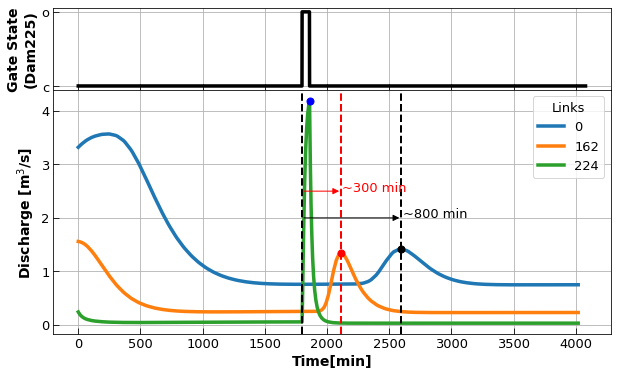

In [208]:
rcParams.update({'font.size': 13,'axes.labelweight':'bold','axes.labelsize':14,\
                            'ytick.major.size':6,'xtick.major.size':6,'xtick.direction':'in','ytick.direction':'in',\
                            'lines.linewidth':3.5})
fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1, 3]}, sharex=True)
ax[0].plot(range(len(states_all)), states_all, c='k')
ax[0].set_yticks([0,1])
ax[0].set_yticklabels(['c', 'o'])
ax[0].grid()
ax[0].set_ylabel('Gate State\n(Dam225)')
dc_travel.plot(y='0', ax=ax[1])
dc_travel.plot(y='162', ax=ax[1])
dc_travel.plot(y='224', ax=ax[1])
ax[1].grid()
ax[1].legend(title='Links')
ax[1].set(xlabel='Time[min]', ylabel='Discharge [m$^3$/s]')
plt.subplots_adjust(hspace=0)
peak0, _ = find_peaks(dc_travel['0'].values)
peak0 =peak0[-1] 
peak162, _ = find_peaks(dc_travel['162'].values)
peak224, _ = find_peaks(dc_travel['224'].values)
ax[1].plot(dc_travel.index[peak0], dc_travel['0'].values[peak0],'ko', ms=7)
ax[1].plot(dc_travel.index[peak162], dc_travel['162'].values[peak162],'ro',ms=7 )
ax[1].plot(dc_travel.index[peak224], dc_travel['224'].values[peak224],'bo',ms=7 )
ax[1].axvline(x=1800, linewidth=2.0, linestyle='dashed', c='k')
ax[1].axvline(x=dc_travel.index[peak0], linewidth=2.0, linestyle='dashed', c='k')
ax[1].axvline(x=dc_travel.index[peak162], linewidth=2.0, linestyle='dashed', c='r')
# ax[1].axvline(x=dc_travel.index[peak224], linewidth=2.0, linestyle='dashed', c='b')

ax[1].annotate('', xy=(1800,2),xytext=(dc_travel.index[peak0],2),arrowprops={'arrowstyle': '<|-', 'color':'k'},)
ax[1].annotate(f'~{800} min', xy=(1800,2),xytext=(dc_travel.index[peak0]+10,2),color='k')

ax[1].annotate('', xy=(1800,2.5),xytext=(dc_travel.index[peak162[0]],2.5),arrowprops={'arrowstyle': '<|-', 'color':'r'},)
ax[1].annotate(f'~{300} min', xy=(1800,2.5),xytext=(dc_travel.index[peak162[0]]+10,2.5),color='r')
fig.savefig('..\\data\\supplement\\travel_time.png',bbox_inches = 'tight', pad_inches = 0.5)

In [22]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-6,)

Model 254 is being used!
87839

In [34]:
SSN2 = Watershed(Model=256)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN2.dam_ids = dams
dam_params256 = SSN2.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN2.set_dam_state(states=[1.0 for _ in range(n_dams)])
SSN2.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive, st_passive = SSN2.Run_256( [0, te], forcing, dam_params256)

Model 256 (254 with_dams) is being used!
4999949999

In [35]:
def RunSimulation(args):
    object, state , t0, forcing, dam_parameters, t_next = args
    object.set_dam_state(states=state)
    dc_test, st_test = object.Run_256( [t0, t0+t_next], forcing, dam_parameters)
    flow_max = dc_test.max(axis=0)
    # volume_max = st_test.max(axis=0)
    # flow_last = dc_test.iloc[-1]
    volume_last = st_test.iloc[-1]
    return [dc_test, st_test]#[flow_max, volume_last]#, 

In [36]:
SSN5 = Watershed(Model=256)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)

Model 256 (254 with_dams) is being used!


In [83]:
population = InitialPopulation2(10, n_dams)
results = []
for state in population:
    sim = RunSimulation([SSN5, state , 0, forcing, dam_params256,120])
    results.append(sim)

120

In [25]:
test = population[2]
test = [2,1,1]

[Text(0, 0.5, 'Streamflow[m$^3$/s]\n Link 35'), Text(0.5, 0, 'Time[min]')]

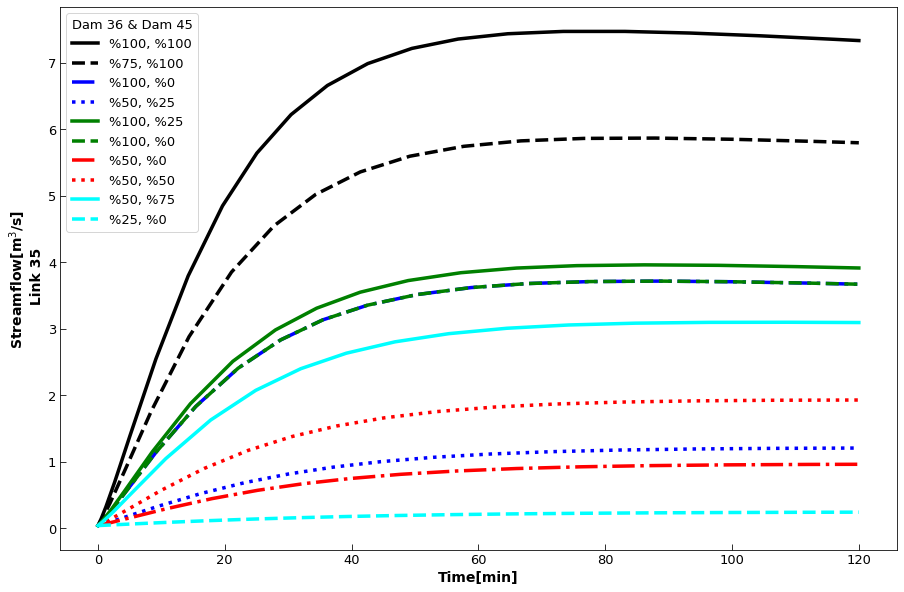

In [85]:
fig, ax = plt.subplots(figsize=(15, 10))

clrs_list=['k','b','g','r', 'cyan'] # list of basic colors
styl_list=['-','--','-.',':', '-'] # list of basic linestyles
i=0
for result in results:
    clrr=clrs_list[i // 2]
    styl=styl_list[i % 4]
    result[0].plot(y='35', ax=ax, label=f'%{int(100*population[i][2])}, %{int(100*population[i][3])}', c=clrr, linestyle=styl)
    i +=1
ax.legend(title=f'Dam {dams[2]} & Dam {dams[3]}',)
ax.set(xlabel='Time[min]', ylabel='Streamflow[m$^3$/s]\n Link 35')

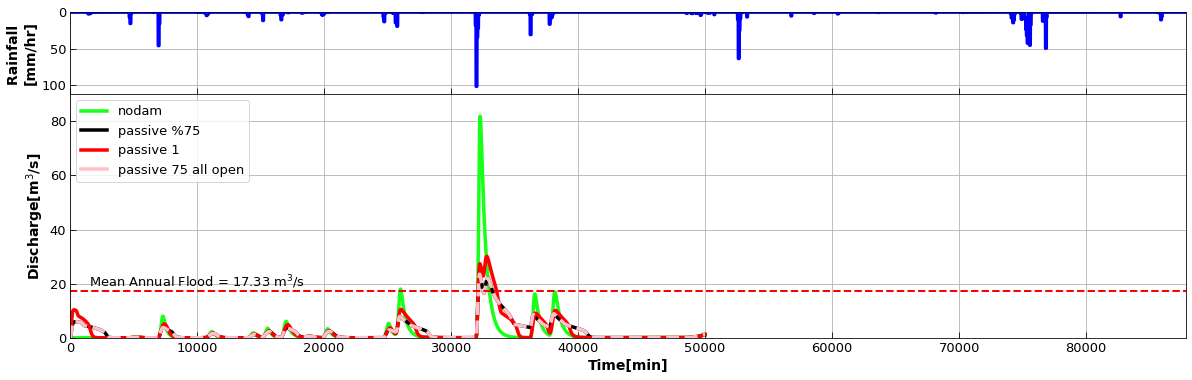

In [87]:
s_name = '_h45_5_O75_1_10_19dams' 
pltKwargs = [{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passive %75', 'color':'k'},{'label':'passive 1', 'color':'red'},{'label':'passive 75 all open', 'color':'pink', 'linestyle':'dashed'}]
plot_sim(81, forcing, [dc_nodam, dc_passive05, dc_passive10, dc_passive10_2], pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)

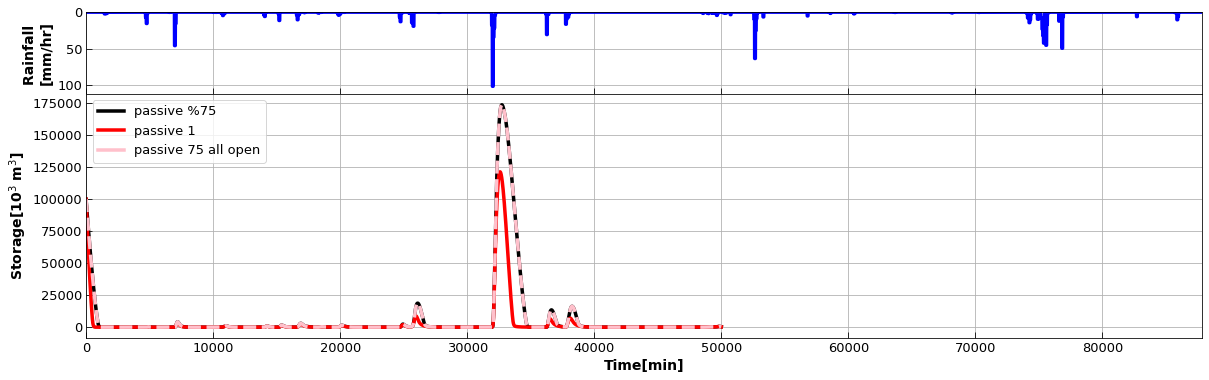

In [31]:
plot_sim(9, forcing, [st_passive05, st_passive10,st_passive10_2], pltKwargs[1:], d_type='storage')

In [47]:

from imp import reload 
import hlm_basic
reload(hlm_basic.tools)
from hlm_basic.tools import plot_sim

In [252]:
x = np.linspace(162000,250000)
y = list(map(lambda x: -math.exp(0.00002*x), x))
x2 = np.linspace(243000,350000)
y2 = list(map(lambda x: -math.exp(0.000014*x), x2))

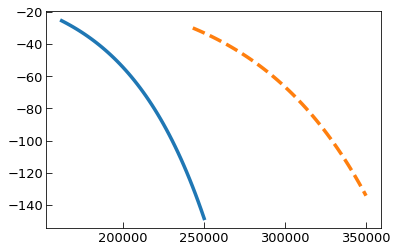

In [253]:
plt.plot(x, y)
plt.plot(x2, y2, linestyle='dashed')